In [1]:
import os
import os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid", color_codes=True)
sns.set(font_scale=1.35, style="ticks") #set styling preferences
import statsmodels.api as sm
from scipy import stats
import math
from math import pi
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans2,vq, whiten
import sidetable
import geopandas as gpd
import h5py
import boto.s3
import glob
import boto3
from zipfile import ZipFile
import shutil

In [2]:
# Show all columns and rows
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [5]:
%%time
s3 = boto3.client("s3")
key = "pilates-outputs/sfbay-rhprice2.0-rhfleet1.0-20220905/beam/year-2018-iteration-5/ITERS/it.0/0.events.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
dtypes = {
    "time": "float32",
    "type": "category",
    "legMode": "category",
    "actType": "category", 
    "primaryFuelLevel": "float64",
    "legMode": "category",
    "chargingPointType":"category",
    "pricingModel":"category",
    "parkingType":"category",
    "mode":"category",
    "personalVehicleAvailable": "category",
    "person": "object",
    "driver": "object",
    "riders": "object",
    'primaryFuelType': "category",
    'secondaryFuelType': 'category',
    'currentTourMode': 'category',
    'currentActivity': 'category',
    'nextActivity': 'category'    
}
eventsSF = pd.read_csv(obj['Body'], compression = 'gzip', dtype = dtypes)

<timed exec>:25: DtypeWarning: Columns (17,22,23,37,41,42,46,48) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 3min 24s
Wall time: 3min 24s


In [6]:
key = "pilates-outputs/sfbay-rhprice2.0-rhfleet1.0-20220905/activitysim/year-2018-iteration-5/final_trips.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
trips = pd.read_csv(obj['Body'], compression = 'gzip')

In [7]:
%%time
baseline2018 = "https://beam-core-act.s3.amazonaws.com/deepDive/CleanData/SanFrancisco/Ridehail_Price/"
sfbase = pd.read_csv(baseline2018 + 'sf_2018_rh_price_2.csv')

<timed exec>:2: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 1min 32s
Wall time: 4min 17s


In [3]:
%%time
comb_stacked_path = "https://beam-core-act.s3.amazonaws.com/deepDive/CleanData/SanFrancisco/Stacked/"
comb_stacked = pd.read_csv(comb_stacked_path + 'sf_2018_stacked_rh_price_fleetsz_2p25.csv')

CPU times: total: 4min 14s
Wall time: 14min 40s


In [27]:
a = comb_stacked[comb_stacked['lever_position_fleetsize']==2.25]

In [29]:
comb_stacked[comb_stacked['mode_choice_planned_BEAM'] != comb_stacked['mode_choice_actual_BEAM']].head()

,IDMerged,tripIndex,scenario,lever,lever_position_fleetsize,Realized_INEXUS,logsum_relative_to_baseline,door_to_door_time_relative_to_baseline,income,actPurpose,lever_position_price,mode_choice_actual_BEAM,mandatoryCat,logsum_trip_Potential_INEXUS,actEndTime,actEndType,actStartTime,actStartType,cost_BEAM,distance_bike,distance_mode_choice,distance_privateCar,distance_ridehail,distance_transit,distance_travelling,distance_walking,duration_in_privateCar,duration_in_ridehail,duration_in_transit,duration_on_bike,duration_travelling,duration_walking,emissionBiodiesel,emissionDiesel,emissionElectricity,emissionFood,emissionGasoline,emission_marginal,fuelBiodiesel,fuelDiesel,fuelElectricity,fuelFood,fuelGasoline,fuel_marginal,fuel_not_Food,mode_choice_planned_BEAM,numPassengers,parkingType,reason,replanning_status,ride_hail_pooled,transit_bus,transit_cable_car,transit_rail,transit_subway,transit_tram,vehicleIds,year,duration_door_to_door,waitTime,mode_choice_actual_5,mode_choice_actual_6,trip_id,person_id,household_id,tour_id,primary_purpose_x,trip_count,purpose,trip_mode_AS_trips,tour_type,tour_category,start,end,duration,tour_mode_AS_tours,earning,person_sex,sex,edu,race,work_at_home,age,value_of_time,free_parking_at_work,num_mand,lcm_county_id,tenure_mover,hh_size,tenure,hh_cars,hh_income,hhsize,income_in_thousands,median_value_of_time,hh_value_of_time,home_is_urban,home_is_rural,auto_ownership,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED,income_quartiles,MedianQuartiles,alpha,socialCarbonCost,Social_INEXUS,Potential_INEXUS_in_dollar,Realized_INEXUS_in_dollar
256,180,59241.0,ridehail,price_fleetsize,2.25,-0.703254,0.831708,296.0,50700.0,Home_to_othdiscr,0.05,car,NaN,0.244296,44168.0,Home,44688.0,othdiscr,1.409505,0.0,7605.930000,3733.654,0.000,0.000000,3872.276000,138.622,181.0,0.0,0.0,0.0,288.0,107.0,0.0,0.000000,0.0,0.0,0.000389,0.000000,0.0,0.000000e+00,0.0,7346.966,5.257461e+06,5.264808e+06,5.257461e+06,ride_hail_pooled,"1.0, 1.0, 0.0, 0.0, 1.0","Residential, Public",ResourceUnavailable RIDE_HAIL_POOLED,1,1,0,0,0,0,0,"body-180, 698322",2018,520.0,232.0,car,car,59241,180,779945,7405,othdiscr,1,othdiscr,TNC_SINGLE,othdiscr,non_mandatory,12.0,17.0,5.0,DRIVEALONEFREE,4700.0,male,1,16.0,white,0,35,1.129980,False,0,6013,own not recent,three,1,two or more,gt30-lt60,3,50.7,8.81,1.129980,False,False,3,-0.703254,-0.731506,-999.703254,-999.719398,-999.703254,-999.714555,-12.074241,-1000.624266,-1000.702354,-1998.370594,-1998.370594,-1998.370594,-1998.370594,-1000.113785,-2002.609909,-1998.417466,-2002.265860,-1998.417466,-11.046186,-0.487343,-0.807432,2ndQ,70000.0,0.1,0.000000,-7.032543,2.442955,-7.032543
378,277,91173.0,ridehail,price_fleetsize,2.25,-0.979787,0.074262,252.0,276000.0,work_to_Home,0.05,ride_hail_pooled,from_M_to_H,-0.003564,43808.0,work,45990.0,Home,13.237752,0.0,40443.616000,0.000,31493.133,0.000000,31493.133000,0.000,0.0,1563.0,0.0,0.0,1563.0,0.0,0.0,0.000000,0.0,0.0,0.004728,0.000409,0.0,0.000000e+00,0.0,0.000,6.396205e+07,6.396205e+07,6.396205e+07,ride_hail,"1.0, 1.0, 1.0, 2.0, 3.0, 2.0, 1.0, 1.0",NaN,ResourceUnavailable RIDE_HAIL,1,3,0,0,0,0,0,"body-277, rideHailVehicle-2226417@default",2018,2182.0,619.0,ride_hail,ride_hail,91173,277,745372,11396,work,1,Home,TNC_SINGLE,work,mandatory,9.0,12.0,3.0,TNC_SINGLE,125000.0,female,2,22.0,white,0,54,10.780311,False,2,6013,own not recent,three,1,two or more,gt150,3,276.0,12.86,10.780311,False,False,2,-999.746072,-999.746672,-6.848226,-6.848569,-7.737887,-7.738127,-49.075553,-1015.153757,-999.989700,-2.840063,-999.630640,-999.630640,-999.630640,-1998.337600,-1998.337600,-1998.337600,-1998.337600,-1998.337600,-6.965391,-0.095197,-0.979787,4thQ,219000.0,0.1,0.020856,-9.818727,-0.035642,-9.797871
1068,592,194490.0,ridehail,price_fleetsize,2.25,-0.534311,-0.014924,144.0,166100.0,escort_to_escort,1.50,walk,from_N_to_N,-0.10

In [53]:
comb_stacked.mode_choice_actual_BEAM.unique()

array(['hov2_teleportation', 'car', 'hov3_teleportation', 'walk',
       'ride_hail', 'car_hov2', 'ride_hail_pooled', 'walk_transit',
       'drive_transit', 'bike', 'car_hov3', 'ride_hail_transit',
       'bike_transit'], dtype=object)

In [33]:
#sfbase[(sfbase['mode_choice_actual_BEAM'] == 'walk')&(sfbase['Realized_INEXUS_in_dollar'] <-20000)].head()

In [47]:
wTime = comb_stacked[['IDMerged', 'tripIndex','end','start','duration', 'household_id','actPurpose',
               'waitTime', 'duration_travelling', 'duration_door_to_door','mode_choice_actual_BEAM', 'lever_position_fleetsize']]

In [48]:
wTime[wTime['IDMerged']== 1583162]

,IDMerged,tripIndex,end,start,duration,household_id,actPurpose,waitTime,duration_travelling,duration_door_to_door,mode_choice_actual_BEAM,lever_position_fleetsize
2666778,1583162,519277361.0,17.0,16.0,1.0,1903246,Home_to_othmaint,460.0,166.0,626.0,ride_hail_pooled,1.00
2666779,1583162,519277361.0,17.0,16.0,1.0,1903246,Home_to_othmaint,245.0,228.0,473.0,ride_hail_pooled,2.25
2666780,1583162,519277361.0,17.0,16.0,1.0,1903246,Home_to_othmaint,64.0,218.0,282.0,ride_hail_pooled,2.25
2666781,1583162,519277361.0,17.0,16.0,1.0,1903246,Home_to_othmaint,261.0,306.0,567.0,ride_hail_pooled,2.25
2666782,1583162,519277361.0,17.0,16.0,1.0,1903246,Home_to_othmaint,971.0,219.0,1190.0,ride_hail_pooled,2.25
2666783,1583162,519277365.0,17.0,16.0,1.0,1903246,othmaint_to_Home,442.0,122.0,564.0,ride_hail_pooled,1.00
2666784,1583162,519277365.0,17.0,16.0,1.0,1903246,othmaint_to_Home,570.0,51.0,621.0,ride_hail_pooled,2.25
2666785,1583162,519277365.0,17.0,16.0,1.0,1903246,othmaint_to_Home,334.0,151.0,485.0,ride_hail_pooled,2.25
2666786,1583162,519277365.0,17.0,16.0,1.0,1903246,othmaint_to_Home,826.0,237.0,1063.0,ride_hail_pooled,2.25
2666787,1583162,519277365.0,17.0,16.0,1.0,1903246,othmaint_to_Home,273.0,313.0,586.0,ride_hail_pooled,2.25


In [63]:
rh_wTime = wTime[(wTime['mode_choice_actual_BEAM'] == 'ride_hail')|(wTime['mode_choice_actual_BEAM'] == 'ride_hail_pooled')]

In [58]:
rh_wTime = wTime[(wTime['mode_choice_actual_BEAM'] == 'ride_hail_transit')&(wTime['lever_position_fleetsize']==2.25)]

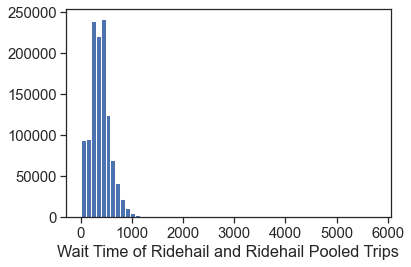

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.hist(rh_wTime['waitTime'], bins=60)
ax.set_xlabel('Wait Time of Ridehail and Ridehail Pooled Trips')
fig.tight_layout()

In [70]:
comb_stacked[(comb_stacked['waitTime']==0)&(comb_stacked['mode_choice_actual_BEAM']=='car')].shape

(5743721, 127)